In [119]:
from os import times
from pylsl import StreamInlet, resolve_stream
from datetime import datetime
from StreamReader import StreamReader
from Classifier import Classifier
import pandas as pd
from Experiment import Experiment
import time
import json
import os
import Filter
from sklearn import preprocessing
import numpy as np
from sklearn.decomposition import FastICA
from scipy.linalg import eigh, eig
import matplotlib.pyplot as plt
import math
from scipy.optimize import minimize

In [120]:
sampleRate = 250

In [121]:
def loadDf(fileName):
    return pd.read_pickle(fileName)

def loadExpMetaData(fileName):
    trialData = []
    with open(fileName, 'r') as file:
        trialData = json.load(file)
    return trialData
def loadSubjectData(datadir, subjectName):
    subjects = os.listdir(datadir)
    subjectDir = datadir + "/" + subjectName 
    df = loadDf(subjectDir + "/" + subjectName + "Imagery.pkl")
    metaData = loadExpMetaData(subjectDir + "/" + subjectName + "ImageryMetadata.json")
    return df, metaData
    

In [122]:
rawData, metaData = loadSubjectData("C:/MI_Project/Stream/data", "zacaria_jan_31")
print(metaData)

[{'trialNumber': 0, 'trialType': 'thinkLeft', 'trialStartTime': 17944.2108146, 'trialEndTime': 17947.089415050003}, {'trialNumber': 1, 'trialType': 'thinkRight', 'trialStartTime': 17949.011210700002, 'trialEndTime': 17951.8888956}, {'trialNumber': 2, 'trialType': 'thinkLeft', 'trialStartTime': 17954.28763275, 'trialEndTime': 17957.1637324}, {'trialNumber': 3, 'trialType': 'thinkRight', 'trialStartTime': 17959.083063, 'trialEndTime': 17962.4460856}, {'trialNumber': 4, 'trialType': 'thinkLeft', 'trialStartTime': 17964.364783750003, 'trialEndTime': 17967.23937175}, {'trialNumber': 5, 'trialType': 'thinkRight', 'trialStartTime': 17969.161369049994, 'trialEndTime': 17972.518827449996}, {'trialNumber': 6, 'trialType': 'thinkLeft', 'trialStartTime': 17974.44004685, 'trialEndTime': 17977.3171614}, {'trialNumber': 7, 'trialType': 'thinkRight', 'trialStartTime': 17979.72617405, 'trialEndTime': 17982.59808705}, {'trialNumber': 8, 'trialType': 'thinkLeft', 'trialStartTime': 17984.51926485, 'trialE

In [123]:
"""
Input : raw trial data as a df with timestamp
Returns : raw data in np format without timestamp, timestamp column of original df to save for later 
"""
def dropTimeStamps(df):
    dfNoTimeStamp = df.drop(["timestamp"], axis=1)
    dataArray = dfNoTimeStamp.to_numpy()
    nonTimeStampColumns = list(dfNoTimeStamp.columns.values)
    return dataArray, df[:]["timestamp"], list(dfNoTimeStamp.columns.values)

In [124]:
npData, timestamps, channelColumnNames = dropTimeStamps(rawData)
print(npData.shape)

(101847, 8)


In [125]:

"""
Input:
     - arr : numpy array containing raw session data
Operation:
     - Average channels and subtract average from all channels
     - Do not take into account the first channel since that's just being used for eyeblink recognition
Returns:
     - Common average referenced singal
"""
def commonAverageReferece(arr):
    commonAverage = np.average(arr[:,1:], 1)
    arr[:,1:] = (arr[:,1:].T - commonAverage).T
    return arr

"""
Input: 
      - arr : numpy array containing raw session data
      - refChannel : eyeblink reference channel.
Operation:
      - performs ICA on the incoming channel
      - zeros the resultant channel that is most similar to the reference channel
      - performs inverse ICA to regain original source signal
Returns:
        - reconstructed signal source
"""
def removeEyeBlinkArtifacts(arr, refChannel):
    ica = FastICA(n_components=8)
    ica.fit(arr)
    components = ica.transform(arr)
    # subtract each component from the first channel and then take the power of the result (sum of each squared sample)
    # the component with the lowest resulting power should correspond to the "eye-blink" signal.
    # make this component 0s and then do an invers ICA transform
    eyeBlinkComponent = -1
    eyeBlinkComponetPower = 0
    i = 0
    for component in components.T:
        compDiff = arr.T[refChannel] - component
        compDiff = np.square(compDiff)
        compPower = np.sum(compDiff, 0) 
        if eyeBlinkComponent == -1 or compPower < eyeBlinkComponetPower:
            eyeBlinkComponetPower = compPower
            eyeBlinkComponent = i
        i+=1
    components = components.T
    components[eyeBlinkComponent] = 0
    components = components.T
    reconstructed = ica.inverse_transform(components)
    arr = reconstructed
    return arr
    
"""
Input: 
    - channel : signal to filter
Operation:
    - applies 2-30 hz bandpass and band stop around 60 hz to eliminate powerline noise
Returns:
    - filtered signal
"""
def filterChannel(channel):
    bandpassed = Filter.butter_bandpass_filter(channel, 0.5, 30, 250, 1)
    bandstopped = Filter.butter_bandstop_filter(bandpassed, 59, 61, 250, 1)
    return bandstopped

"""
Input: 
    - arr : multicahnnel input siganl
Operation:
    - applies 2-250 hz bandpass and band stop around 60 hz bandstop on each channel in the source signal
Returns:
    - filtered signal
"""
def filterData(arr):
    channelBySampleArray = arr.T
    numChannels = channelBySampleArray.shape[0]
    for i in range(numChannels):
        channelBySampleArray[i] = filterChannel(channelBySampleArray[i])
    return channelBySampleArray.T


In [126]:
#npData = removeEyeBlinkArtifacts(npData, 0)
npData = commonAverageReferece(npData)
npData = filterData(npData)

In [127]:
def reconstructDf(npArr, timeStamp, channelColumnNames):
    newDf = pd.DataFrame(npArr, columns=channelColumnNames)
    newDf = newDf.assign(timestamp=timeStamp)
    return newDf

In [128]:
df = reconstructDf(npData, timestamps, channelColumnNames)
print(df)
print(metaData)

          channel1    channel2     channel3     channel4    channel5  \
0        86.092593 -396.728299   972.194630  -280.518244 -318.758782   
1      -459.783596   77.378683  -732.859092   389.322230  279.623884   
2      -724.351781  368.318741 -1685.987880   746.597308  612.247386   
3      -731.455527  417.433600 -1792.081179   776.477120  648.454334   
4      -691.879206  345.230873 -1582.374823   704.205065  575.410094   
...            ...         ...          ...          ...         ...   
101842 -971.442167  340.038393 -2516.682284  1256.450846  875.398675   
101843 -985.019131  329.077104 -2524.500152  1265.767536  876.692397   
101844 -959.480849  309.095737 -2433.204203  1224.636271  844.557576   
101845 -786.997558  256.488059 -1995.887578  1003.812759  693.199449   
101846 -412.366589  122.183002 -1020.767863   520.356049  352.795600   

           channel6     channel7     channel8     timestamp  
0       -318.503067   627.449307  -285.135545  17944.189079  
1        31

In [129]:
"""
Input: 
      - df : raw data from session
      - metadata : data tracking trial types and timestamps from the experiment
Operation:
      - splits the raw session data into trials 
      - all right handed trials are filled first
      - there are an equal number of trials 
Returns:
        - data in a NumTrials x NumSamples x NumChannels numpy array
"""
def splitRawDataIntoTrialsByType(df, metaData):
    rightTrials = []
    leftTrials = []
    for i in range(len(metaData)):
        trial = metaData[i]
        trialStartTimeValMask = df["timestamp"] == float(trial["trialStartTime"])
        trialStartIndex = df["timestamp"][trialStartTimeValMask].index.values[0]
        # make trial end time = trialStartTime + trialLength, so that we standardize triallengths
        # trial length is 750 = 3 sec * 250 Hz
        trialEndIndex = trialStartIndex + 750 
        trialDf = df.iloc[trialStartIndex:trialEndIndex,:]
        trialDf = trialDf.reset_index(drop=True)
        trialDf.drop('timestamp', axis=1, inplace=True) # no longer need timestamp
        if trial["trialType"] == "thinkRight":
            rightTrials.append(trialDf)
        elif trial["trialType"] == "thinkLeft":
            leftTrials.append(trialDf) 
    rightTrialsArray = np.array(rightTrials)
    leftTrialsArray = np.array(leftTrials)
    allData = np.concatenate((rightTrialsArray, leftTrialsArray))
    return allData

In [130]:
trialSplitData = splitRawDataIntoTrialsByType(df, metaData)


In [131]:
def scaleData(arr):
    scaler = preprocessing.StandardScaler()
    num_instances, num_time_steps, num_features = arr.shape
    arr = np.reshape(arr, newshape=(-1, num_features))
    arr = scaler.fit_transform(arr)
    arr = np.reshape(arr, newshape=(num_instances, num_time_steps, num_features))
    return scaler, arr
        

In [132]:
scaler, scaledTrialData = scaleData(trialSplitData)

In [133]:
def calculateAvgPowerforTrialType(arr, trialType):
    numTrials = arr.shape[0]
    numSamples = arr.shape[1]
    trialRange = range(math.floor(numTrials/2)) if trialType == "right" else range(math.floor(numTrials/2), numTrials)
    print(trialRange)
    freqAmplitudes = None
    freqs = None
    firstTime = True
    for i in trialRange:
        if firstTime:
            freqAmplitudes = np.abs(np.fft.fft(arr[i], axis=1))
            freqs = np.fft.fftfreq(n=numSamples, d=1/sampleRate)
            firstTime = False
        else:
            freqAmplitudes = np.add(freqAmplitudes, np.abs(np.fft.fft(arr[i], axis=1)))
    print(freqs.shape)
    print(freqAmplitudes.shape)
    freqs = freqs[:math.floor(len(freqs)/2)]
    freqAmplitudes = freqAmplitudes[:math.floor(len(freqAmplitudes)/2)]
    freqAmplitudes = freqAmplitudes / (numTrials/2)
    return freqs, freqAmplitudes

In [134]:
def plotFrequencyPowers(rfreqs, rfreqAmplitudes, lfreqs, lfreqAmplitudes, ax):
    ax.plot(rfreqs, rfreqAmplitudes, 'b')
    ax.plot(lfreqs, lfreqAmplitudes, 'r')
    ax.set_xlabel('Freq (Hz)')
    ax.set_ylabel('FFT Amplitude |X(freq)|')
    ax.set_xlim(0, 40)
    ax.set_ylim(0,np.amax([np.amax(rfreqAmplitudes), np.amax(lfreqAmplitudes)]))

def plotFreqPowerForAllChannels(rfreqs, rfreqAmplitudes, lfreqs, lfreqAmplitudes):
    plt.close('all')
    fig = plt.figure()
    fig.set_figheight(10)
    fig.set_figwidth(15)
    
    axes = []
    numChannels = rfreqAmplitudes.shape[1]
    for i in range(numChannels):
        rowIndex = 0 if i < 4 else 1
        colIndex = i % 4
        ax = plt.subplot2grid((2, 4), (rowIndex, colIndex))
        plotFrequencyPowers(rfreqs, rfreqAmplitudes[:, i], lfreqs, lfreqAmplitudes[:, i], ax)
        axes.append(ax)
    
    plt.tight_layout()
    plt.show()
    
def plotTimeseries(arr):
    print(arr.shape[0])
    time = np.arange(arr.shape[0])
    plt.figure(figsize=(10,10))
    i = 1
    for i in range(arr.shape[1]):
        plt.ylim((-6,6))
        plt.subplot(9, 1, i+1)
        plt.plot(time, arr[:,i], "b")
        plt.xlabel('Sample')
        plt.ylabel('Amplitude')
        plt.tight_layout()
    plt.show()
    
def plotTrialChannels(rightChannel1, rightChannel2, leftChannel1, leftChannel2):
    plt.ylim((-10,10))
    plt.xlim((-10,10))
    plt.plot(rightChannel1, rightChannel2, 'bo')
    plt.plot(leftChannel1, leftChannel2, 'ro')
    plt.show()
    

range(0, 40)
(750,)
(750, 8)
range(40, 80)
(750,)
(750, 8)


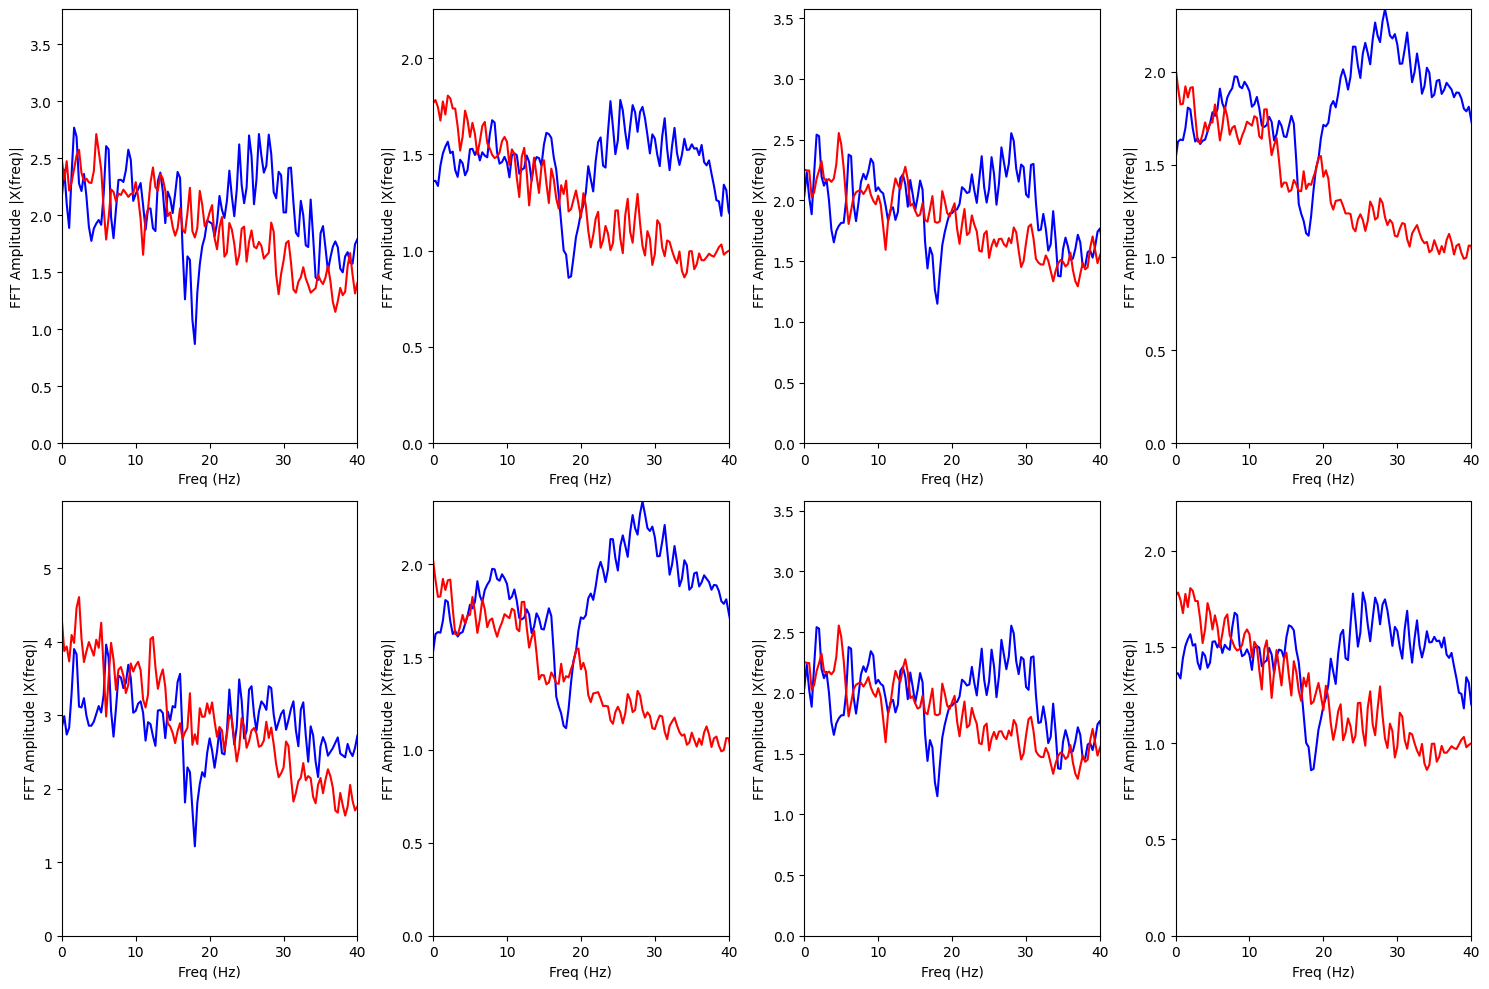

750


C:\Users\Zacky2\AppData\Local\Temp\ipykernel_12892\3972177827.py:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(9, 1, i+1)


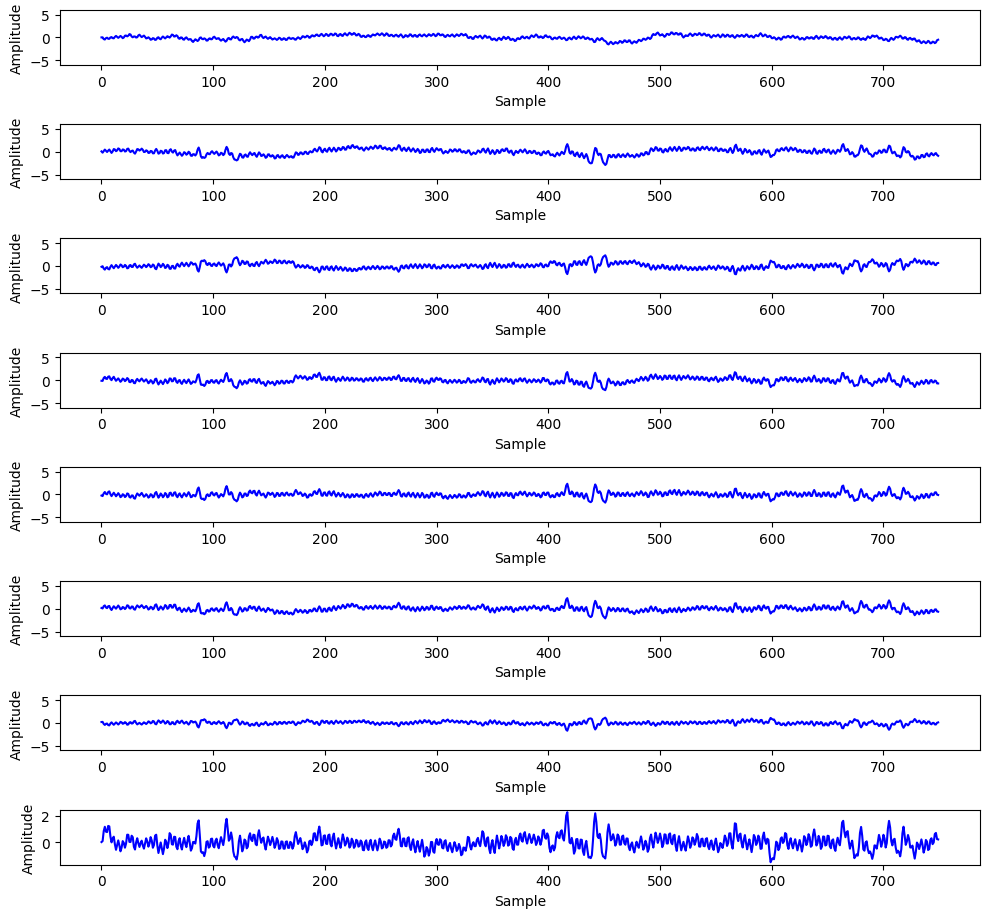

In [135]:
rightFreqs, rightFreqAmplitudes = calculateAvgPowerforTrialType(scaledTrialData, "right")
leftFreqs, leftFreqAmplitudes = calculateAvgPowerforTrialType(scaledTrialData, "left")


plotFreqPowerForAllChannels(rightFreqs, rightFreqAmplitudes, leftFreqs, leftFreqAmplitudes)

plotTimeseries(scaledTrialData[2])

In [136]:
"""
Input: 
    - arr : array to estimate covariance of, in this case a timeseries of EEG data
Operation:
    - calculate to covariance of the matrix !
Returns:
    - covariance matrix
"""
def calculateCovarianceEstimate(arr):
    # covariance matrix is numChannels x numChannels
    covar = np.zeros(shape=(arr.shape[2], arr.shape[2]))
    numTrials = arr.shape[0]
    for trial in arr:
        numSamples = trial.shape[0]
        #trialMean = 1/numSamples * trial.sum(0)
        #trialCovar = np.zeros(shape=(arr.shape[2], arr.shape[2]))
        #for sample in trial:
            #trialCovar += np.matmul(sample - trialMean, (sample - trialMean).T)
        #trialCovar *= 1/(numSamples - 1)
        trialCovar = np.matmul(trial.T,trial)
        trialCovar /= numSamples
        #trialCovar /= np.trace(trialCovar)
        covar += trialCovar
    covar *= 1/numTrials
    return covar

"""
Input:
    - A : matrix 1
    - B: matrix 2
Operation:
    - Calculates the generalized eigenvectors/values for A with respect to B
Returns:
    - list of eigen values and vectors, sorted by eigenvalue 
"""
def calculateGeneralizedEigenVectors(A, B):
    #eigvals, eigvecs = eig(A, A + B)
    invA = np.linalg.inv(A)
    mult = np.matmul(invA, B)
    eigvals, eigevs = eig(mult)
    return eigvals, eigvecs

"""
Input:
    - eigvecs: list of eigenvectors
    - halfNumFilters: half the number of filtered channels we want (6)
Operation:
    - creates W filter for the incoming source signal
Returns: 
    - filter ! 
"""
def createFilter(eigvecs, halfNumFilters):
    eigvecs = eigvecs.T
    filterCollector = []
    for i in range(len(eigvecs)):
        if (i < halfNumFilters or i >= len(eigvecs) - halfNumFilters):
            filterCollector.append(eigvecs[i])
    return np.array(filterCollector)

"""
Input:
    - filter: W filter 
    - arr: half the number of filtered channels we want (6)
Operation:
    - creates W filter for the incoming source signal
Returns: 
    - filter ! 
"""
def applySpatialFilter(filter, arr):
    arr = arr.T
    arr = np.matmul(filter, arr)
    arr = arr.T
    return arr

In [137]:
def raleighQuotient(x, A, B):
    numerator = np.matmul(x.T, np.matmul(A, x))
    denominator = np.matmul(x.T, np.matmul(B, x))
    return np.divide(numerator, denominator)

def maximizeRayleigh(A, B):
    maxEigenValue = np.ones(A.shape[0])
    optimizationResult = minimize(raleighQuotient, maxEigenValue, (A, B), method = 'COBYLA')
    print(optimizationResult)
    print(maxEigenValue)

In [138]:
#Transform data

rightCovar = calculateCovarianceEstimate(scaledTrialData[:40])
leftCovar = calculateCovarianceEstimate(scaledTrialData[40:])
### calculate generalized eigenvalues of covariance matrices 
eigvals, eigvecs = calculateGeneralizedEigenVectors(rightCovar, leftCovar)
idx = eigvals.argsort()[::-1]   
eigvals = eigvals[idx]
print(eigvals)
eigvecs = eigvecs[:,idx]

#print(eigvals)
spatialFilter = createFilter(eigvecs, 3)
spatialFilteredTrials = []
for trial in scaledTrialData:
    spatialFilteredTrials.append(applySpatialFilter(spatialFilter, trial))
spatialFilteredTrials = np.array(spatialFilteredTrials)


[ 2.44302507+0.j          1.13693075+0.j          0.89414169+0.j
  0.83489658+0.06421591j  0.83489658-0.06421591j  0.65726265+0.j
  0.19312521+0.j         -1.34961551+0.j        ]


In [139]:
# calculate features for data

feature_data = []
for trial in spatialFilteredTrials:
    trial = trial.T
    features = []
    for filteredChannel in trial:
        power = np.matmul(filteredChannel, filteredChannel.T)
        logPower = np.log(power)
        features.append(logPower)
    features = np.array(features)
    feature_data.append(features)
feature_data = np.array(feature_data)
Y_right = np.ones(40)
Y_left = np.zeros(40)
Y = np.concatenate((Y_right, Y_left))

In [140]:
#create classifier
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression(solver='liblinear', random_state=0)
classifier.fit(feature_data, Y)
print(classifier.score(feature_data, Y))
print(classifier.predict(feature_data[0].reshape(1, -1)))
print(classifier.coef_)

0.575
[0.]
[[ 0.0188472   0.02944426 -0.10186246 -0.00790505 -0.04704603  0.14464923]]


In [141]:
### Try calculating common/discriminative 
### then maximize rayleigh quotient to find largest eigenvector  
commonActivity = np.add(rightCovar, leftCovar)
discriminativeActivity = np.subtract(leftCovar, rightCovar)
#print(commonActivity)
#print(discriminativeActivity)
maximizeRayleigh(commonActivity, discriminativeActivity)

     fun: 405558.0178163308
   maxcv: 0.0
 message: 'Optimization terminated successfully.'
    nfev: 111
  status: 1
 success: True
       x: array([ 3.61034604,  2.97461503,  1.72999075,  1.18443925,  1.47902352,
       -0.97020079,  2.18725624, -1.38883665])
[1. 1. 1. 1. 1. 1. 1. 1.]


range(0, 40)
(750,)
(750, 6)
range(40, 80)
(750,)
(750, 6)


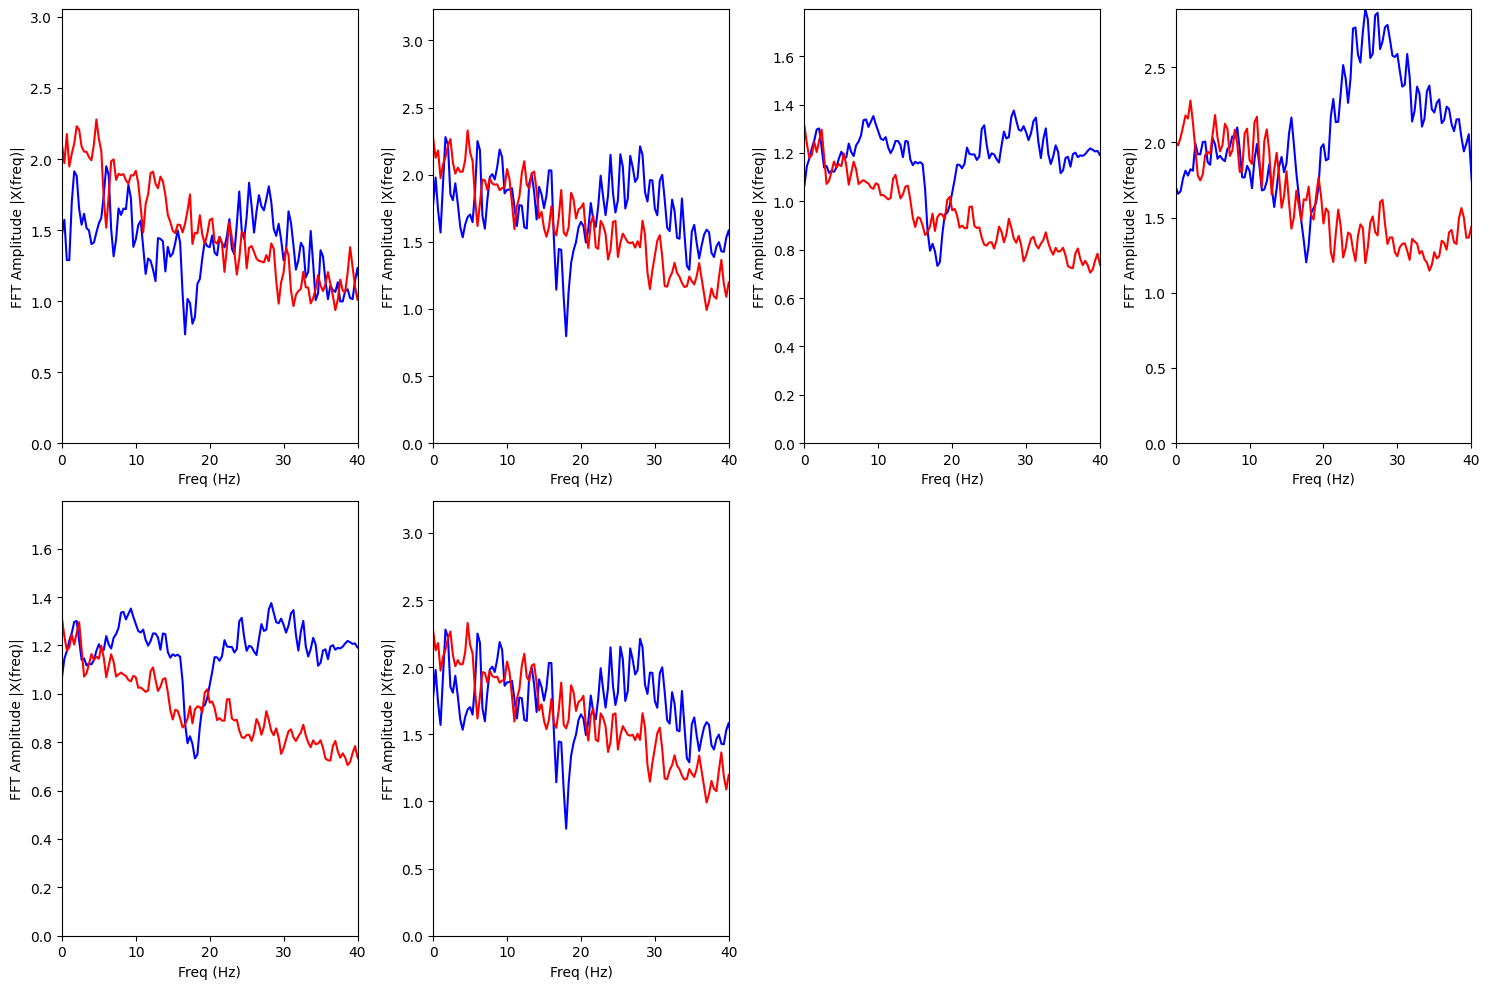

750


C:\Users\Zacky2\AppData\Local\Temp\ipykernel_12892\3972177827.py:34: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(9, 1, i+1)


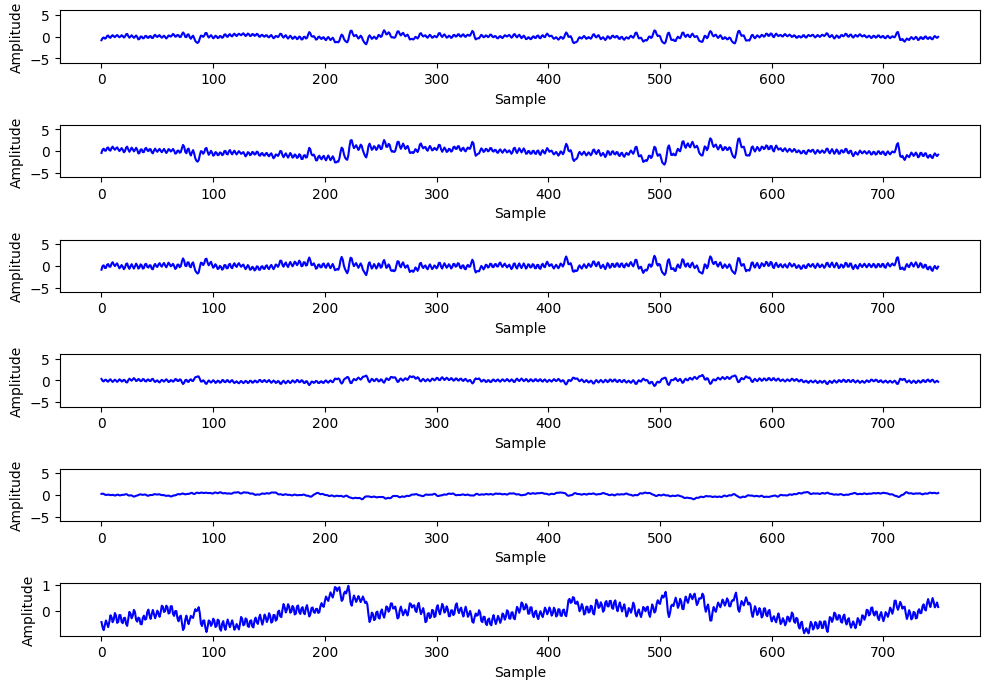

750


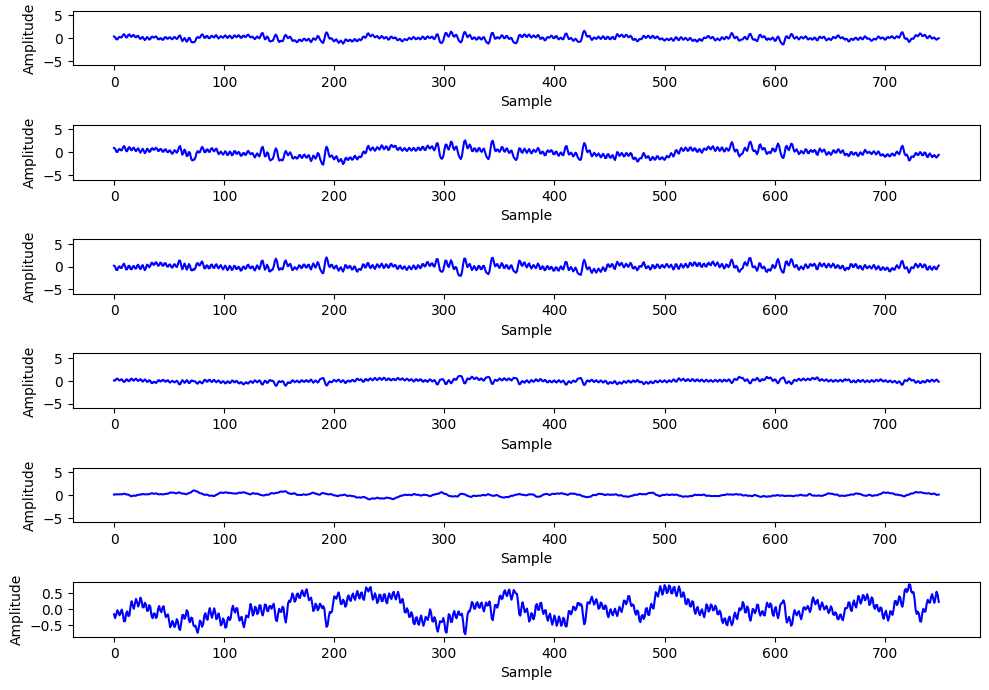

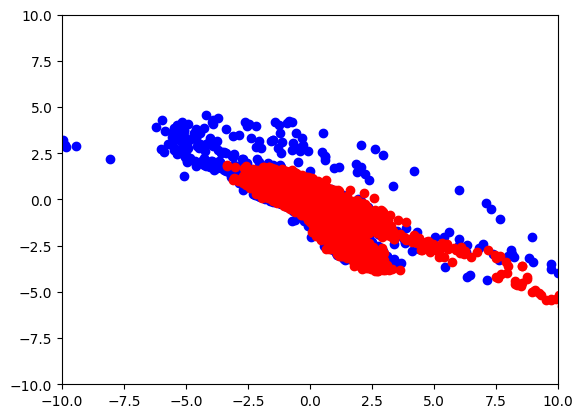

In [142]:
rightFreqs, rightFreqAmplitudes = calculateAvgPowerforTrialType(spatialFilteredTrials, "right")
leftFreqs, leftFreqAmplitudes = calculateAvgPowerforTrialType(spatialFilteredTrials, "left")


plotFreqPowerForAllChannels(rightFreqs, rightFreqAmplitudes, leftFreqs, leftFreqAmplitudes)

plotTimeseries(spatialFilteredTrials[10])
plotTimeseries(spatialFilteredTrials[60])
channel1 = 2
channel2 = 3

rightTrialsChannel1 = spatialFilteredTrials[0:40,:,channel1]
rightTrialsChannel1 = rightTrialsChannel1.flatten()
leftTrialsChannel1 = spatialFilteredTrials[40:,:,channel1]
leftTrialsChannel1 = leftTrialsChannel1.flatten()

rightTrialsChannel2 = spatialFilteredTrials[0:40,:,channel2]
rightTrialsChannel2 = rightTrialsChannel2.flatten()
leftTrialsChannel2 = spatialFilteredTrials[40:,:,channel2]
leftTrialsChannel2 = leftTrialsChannel2.flatten()
plotTrialChannels(rightTrialsChannel1, rightTrialsChannel2, 
                  leftTrialsChannel1, leftTrialsChannel2)